In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re 
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import confusion_matrix, classification_report, balanced_accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

%matplotlib inline

[nltk_data] Error loading stopwords: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>


In [2]:
data = pd.read_csv('amazon_alexa.tsv', delimiter='\t')
data.head()

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1
4,5,31-Jul-18,Charcoal Fabric,Music,1


In [3]:
data.tail()

,rating,date,variation,verified_reviews,feedback
3145,5,30-Jul-18,Black Dot,"Perfect for kids, adults and everyone in betwe...",1
3146,5,30-Jul-18,Black Dot,"Listening to music, searching locations, check...",1
3147,5,30-Jul-18,Black Dot,"I do love these things, i have them running my...",1
3148,5,30-Jul-18,White Dot,Only complaint I have is that the sound qualit...,1
3149,4,29-Jul-18,Black Dot,Good,1


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3150 entries, 0 to 3149
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   rating            3150 non-null   int64 
 1   date              3150 non-null   object
 2   variation         3150 non-null   object
 3   verified_reviews  3149 non-null   object
 4   feedback          3150 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 123.2+ KB


In [5]:
data.isnull().sum()

rating              0
date                0
variation           0
verified_reviews    1
feedback            0
dtype: int64

In [6]:
data.shape

(3150, 5)

In [7]:
data.describe()

,rating,feedback
count,3150.000000,3150.000000
mean,4.463175,0.918413
std,1.068506,0.273778
min,1.000000,0.000000
25%,4.000000,1.000000
50%,5.000000,1.000000
75%,5.000000,1.000000
max,5.000000,1.000000


# Analysis and Visualization

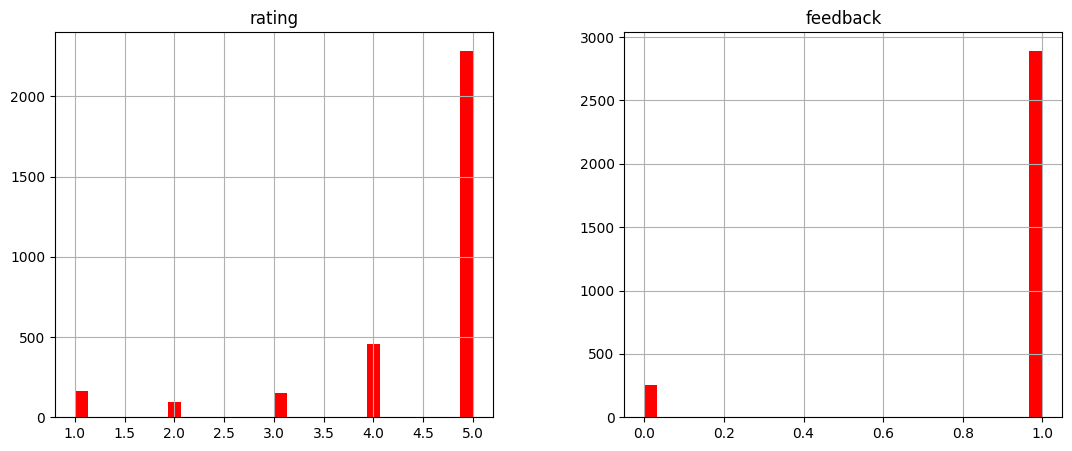

In [8]:
data.hist(bins = 30, figsize = (13,5), color = 'r')
plt.show()

we can see that rating distribution indicates a dominant positive feedback as almost 3000 reviews are labeled as positive, with average value of ~ 4.5 and standard deviation of 1

In [9]:
data['verified_reviews'] = data['verified_reviews'].fillna("").astype(str)

data['review length'] = data['verified_reviews'].apply(len)

print(data.head())

   rating       date         variation  \
0       5  31-Jul-18  Charcoal Fabric    
1       5  31-Jul-18  Charcoal Fabric    
2       4  31-Jul-18    Walnut Finish    
3       5  31-Jul-18  Charcoal Fabric    
4       5  31-Jul-18  Charcoal Fabric    

                                    verified_reviews  feedback  review length  
0                                      Love my Echo!         1             13  
1                                          Loved it!         1              9  
2  Sometimes while playing a game, you can answer...         1            195  
3  I have had a lot of fun with this thing. My 4 ...         1            172  
4                                              Music         1              5  


In [10]:
# Let's get the length of the reviews

data['review length'] = data['verified_reviews'].apply(len)
data.head()

,rating,date,variation,verified_reviews,feedback,review length
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1,13
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1,9
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1,195
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1,172
4,5,31-Jul-18,Charcoal Fabric,Music,1,5


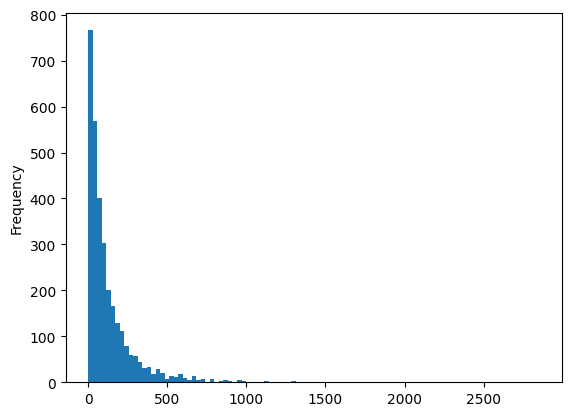

In [11]:
data['review length'].plot(bins=100, kind='hist') 
plt.show()

Most reviews do not exceed 500-character long. Let's compare the length of reviews based on rating

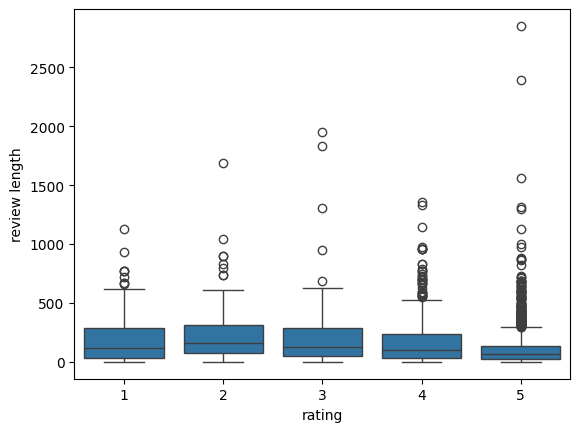

In [12]:
sns.boxplot(x='rating', y='review length', data=data)
plt.show()

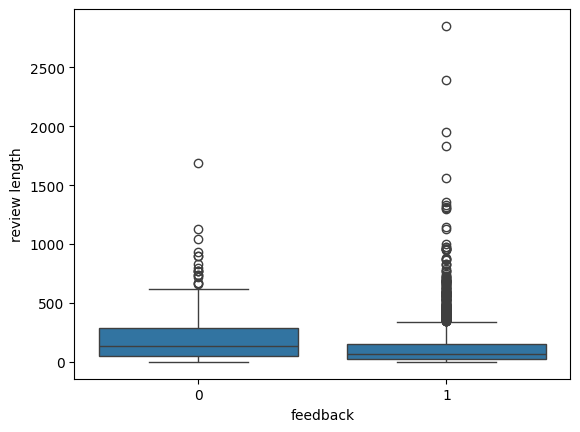

In [13]:
sns.boxplot(x='feedback', y='review length', data=data)
plt.show()

we can observe that reviews tend to be longer with lower ratings indicating that users tend to be more expressive in negative experiences

C:\Users\gnana\AppData\Local\Temp\ipykernel_13052\161684021.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = 'variation', y='rating', data = data, palette = 'deep')


<Axes: xlabel='variation', ylabel='rating'>

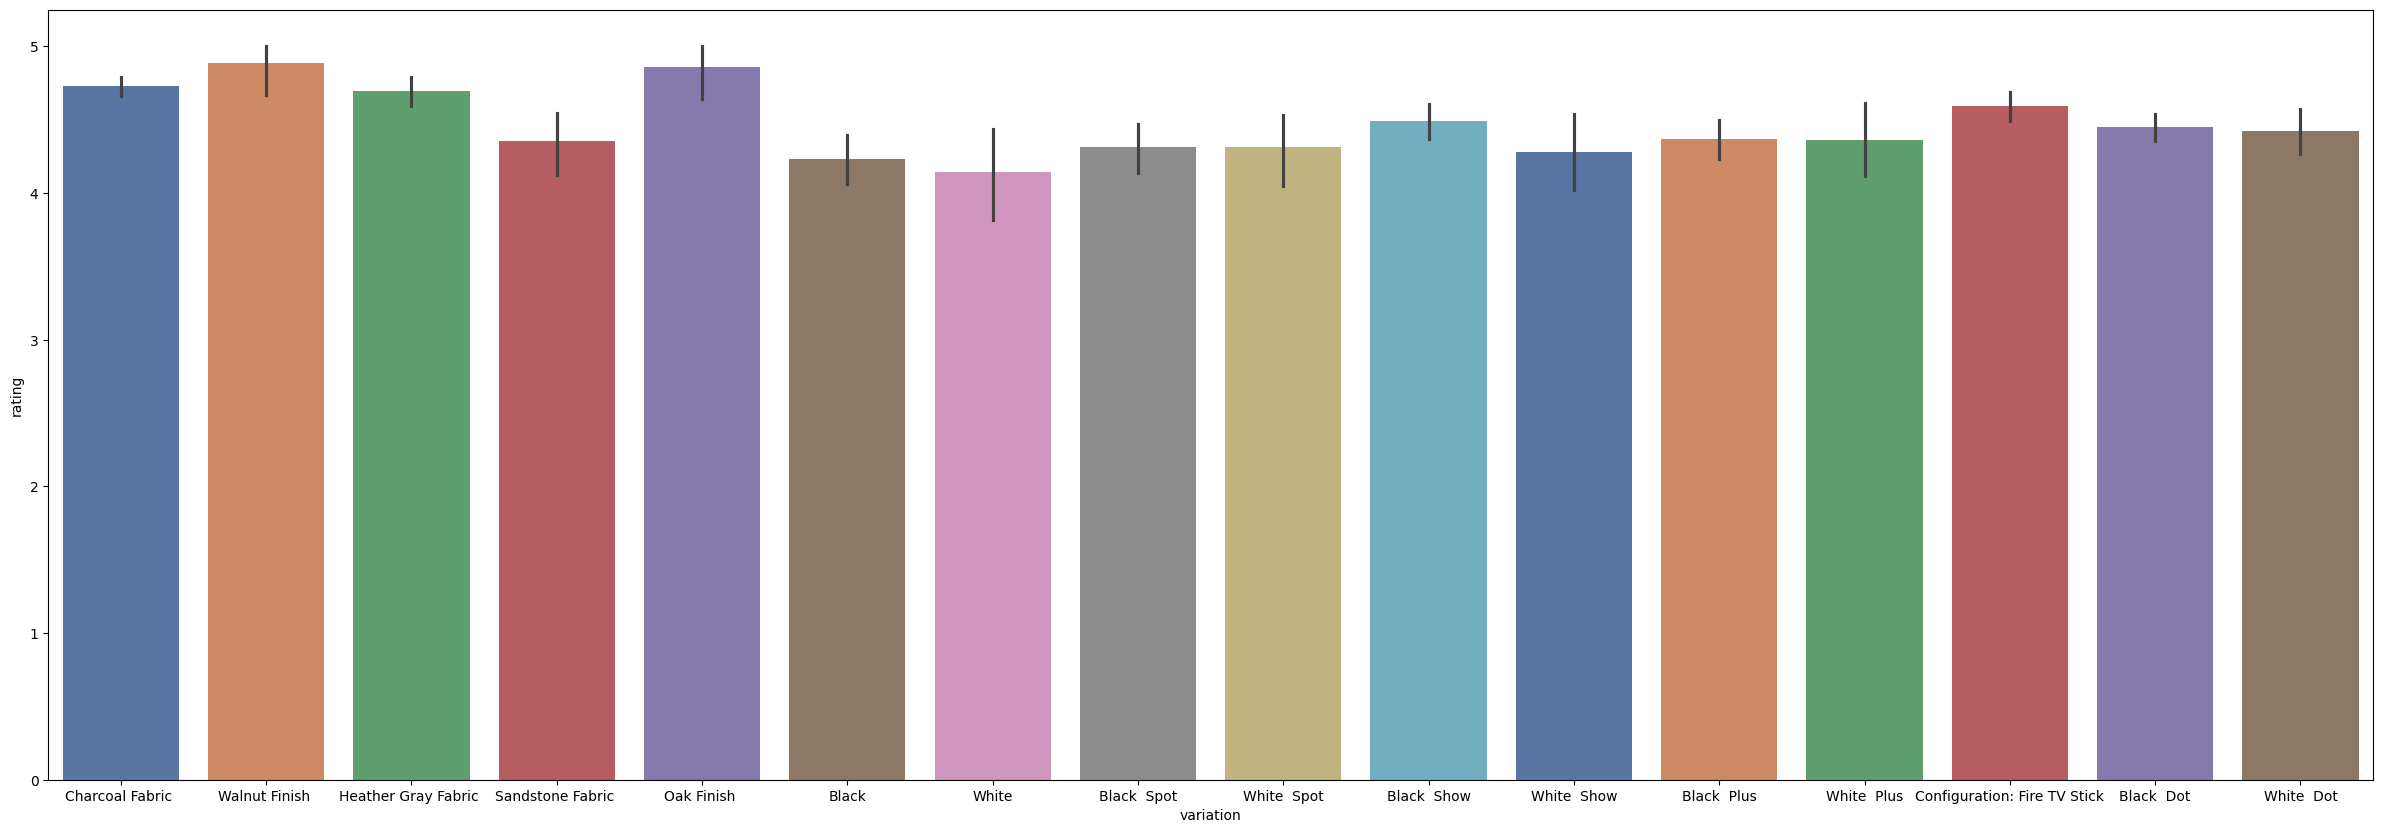

In [14]:
plt.figure(figsize = (30,10))
sns.barplot(x = 'variation', y='rating', data = data, palette = 'deep')

Different variations has no significant impact on the rating, However, Oak finish is slightly more highly rated than other variations

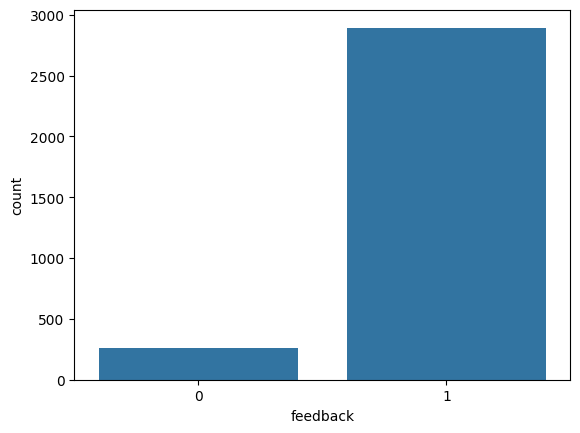

In [15]:
sns.countplot(x = 'feedback', data = data)
plt.show()

Positive feedback is much higher than negative ones so we expect our model to be biased toward the positive instances

# Data Preprocessing

In [16]:
# drop unnecessary columns
data.drop(['date', 'variation', 'rating', 'review length'],axis=1, inplace=True)

In [17]:
data.head()

,verified_reviews,feedback
0,Love my Echo!,1
1,Loved it!,1
2,"Sometimes while playing a game, you can answer...",1
3,I have had a lot of fun with this thing. My 4 ...,1
4,Music,1


In [22]:
corpus = []
for i in range(len(data)):
  review = re.sub('[^a-zA-Z]', ' ', data['verified_reviews'][i]) # remove all what's not a character
  review = review.lower().split()
  ps = PorterStemmer()
  all_stop_words = stopwords.words('english')
  all_stop_words.remove('not')
  review = [ps.stem(word) for word in review if not word  in set(all_stop_words)]  # remove stop words, perform stemming
  review = ' '.join(review)
  corpus.append(review)

In [23]:
corpus[:10]

['love echo',
 'love',
 'sometim play game answer question correctli alexa say got wrong answer like abl turn light away home',
 'lot fun thing yr old learn dinosaur control light play game like categori nice sound play music well',
 'music',
 'receiv echo gift need anoth bluetooth someth play music easili access found smart speaker wait see els',
 'without cellphon cannot use mani featur ipad not see use great alarm u r almost deaf hear alarm bedroom live room reason enough keep fun ask random question hear respons not seem smartbon polit yet',
 'think th one purchas work get one everi room hous realli like featur offer specifili play music echo control light throughout hous',
 'look great',
 'love listen song heard sinc childhood get news weather inform great']

In [91]:
!pip install textblob


   ---------------------------------------- 0.0/626.3 kB ? eta -:--:--
    --------------------------------------- 10.2/626.3 kB ? eta -:--:--
    --------------------------------------- 10.2/626.3 kB ? eta -:--:--
    --------------------------------------- 10.2/626.3 kB ? eta -:--:--
   - ------------------------------------- 30.7/626.3 kB 109.5 kB/s eta 0:00:06
   - ------------------------------------- 30.7/626.3 kB 109.5 kB/s eta 0:00:06
   -- ------------------------------------ 41.0/626.3 kB 115.9 kB/s eta 0:00:06
   -- ------------------------------------ 41.0/626.3 kB 115.9 kB/s eta 0:00:06
   -- ------------------------------------ 41.0/626.3 kB 115.9 kB/s eta 0:00:06
   --- ----------------------------------- 61.4/626.3 kB 131.3 kB/s eta 0:00:05
   --- ----------------------------------- 61.4/626.3 kB 131.3 kB/s eta 0:00:05
   ----- --------------------------------- 81.9/626.3 kB 143.4 kB/s eta 0:00:04
   ----- --------------------------------- 81.9/626.3 kB 143.4 kB/s eta 0

In [24]:
from textblob import TextBlob

In [25]:
from textblob import TextBlob


# Function to determine sentiment
def predict_sentiment(review):
    
    analysis = TextBlob(review)
    # Polarity ranges from -1 (negative) to 1 (positive)
    if analysis.sentiment.polarity > 0:
        return "Positive"
    elif analysis.sentiment.polarity < 0:
        return "Negative"
    else:
        return "Neutral"

# Apply the function to predict sentiment
data['Sentiment'] = data['verified_reviews'].apply(lambda x: predict_sentiment(x))

# Display the DataFrame
print(data)
sentence = "a there is a beautiful flower"
result = predict_sentiment(sentence)
print(f"Sentence: {sentence}")
print(f"Sentiment: {result}")

                                       verified_reviews  feedback Sentiment
0                                         Love my Echo!         1  Positive
1                                             Loved it!         1  Positive
2     Sometimes while playing a game, you can answer...         1  Negative
3     I have had a lot of fun with this thing. My 4 ...         1  Positive
4                                                 Music         1   Neutral
...                                                 ...       ...       ...
3145  Perfect for kids, adults and everyone in betwe...         1  Positive
3146  Listening to music, searching locations, check...         1  Positive
3147  I do love these things, i have them running my...         1  Positive
3148  Only complaint I have is that the sound qualit...         1  Positive
3149                                               Good         1  Positive

[3150 rows x 3 columns]
Sentence: a there is a beautiful flower
Sentiment: Positive


In [26]:
data["Sentiment"].unique()

array(['Positive', 'Negative', 'Neutral'], dtype=object)

In [27]:
X=corpus
X

['love echo',
 'love',
 'sometim play game answer question correctli alexa say got wrong answer like abl turn light away home',
 'lot fun thing yr old learn dinosaur control light play game like categori nice sound play music well',
 'music',
 'receiv echo gift need anoth bluetooth someth play music easili access found smart speaker wait see els',
 'without cellphon cannot use mani featur ipad not see use great alarm u r almost deaf hear alarm bedroom live room reason enough keep fun ask random question hear respons not seem smartbon polit yet',
 'think th one purchas work get one everi room hous realli like featur offer specifili play music echo control light throughout hous',
 'look great',
 'love listen song heard sinc childhood get news weather inform great',
 'sent year old dad talk constantli',
 'love learn knew thing eveyday still figur everyth work far easi use understand make laugh time',
 'purchas mother knee problem give someth tri come not get around fast like enjoy littl b

In [28]:
y = data['feedback']
y

0       1
1       1
2       1
3       1
4       1
       ..
3145    1
3146    1
3147    1
3148    1
3149    1
Name: feedback, Length: 3150, dtype: int64

## Split the dataset into the Training set and Test set

In [29]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Model Development

## Logistic Regression

In [30]:
from sklearn.linear_model import LogisticRegression
model= Pipeline([
                  ('count', CountVectorizer()),
                  ('tfidf', TfidfTransformer()),
                  ('clf', LogisticRegression()),
                  ])
model.fit(X_train, y_train)

Pipeline(steps=[('count', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression())])

In [31]:
y_hat = model.predict(X_test)
confusion_matrix(y_test, y_hat)

array([[  2,  44],
       [  0, 584]], dtype=int64)

In [32]:
print(classification_report(y_test, y_hat))

              precision    recall  f1-score   support

           0       1.00      0.04      0.08        46
           1       0.93      1.00      0.96       584

    accuracy                           0.93       630
   macro avg       0.96      0.52      0.52       630
weighted avg       0.94      0.93      0.90       630



In line with our expectation, there is a strong bias toward the majority class, with no false positive instances yet high misclassification rate of the minority class. 
we will compare the performance of Logistic regression with that of `SVM` and `Random Forest`

## Suppor Vector Machine

In [33]:
from sklearn.svm import SVC
model_sv = Pipeline([
                  ('count', CountVectorizer(ngram_range=(1,2))),
                  ('tfidf', TfidfTransformer()),
                  ('clf', SVC(kernel='linear')),
                  ])

In [34]:
# grid search to find best n-gram range, svm kernel and regularization parameter
parameters = {'count__ngram_range':[(1, 1), (1, 2)], 
              'tfidf__use_idf': [True, False],
              'clf__kernel': ['linear', 'rbf'], 
              'clf__C': [.0001, .001, 0.1, 1]}
            
grid_search = GridSearchCV(model_sv,
                           param_grid = parameters,
                           scoring = 'balanced_accuracy',
                           cv = 10)
                          
grid_search.fit(X_train, y_train)
accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_
print('Best Accuracy: {:.2f} %'.format(accuracy*100))
print('Best Parameters:', best_parameters)

Best Accuracy: 66.59 %
Best Parameters: {'clf__C': 1, 'clf__kernel': 'linear', 'count__ngram_range': (1, 2), 'tfidf__use_idf': True}


In [35]:
model_sv.fit(X_train, y_train)
confusion_matrix(y_test, model_sv.predict(X_test))

array([[ 17,  29],
       [  7, 577]], dtype=int64)

In [36]:
print(classification_report(y_test, model_sv.predict(X_test)))

              precision    recall  f1-score   support

           0       0.71      0.37      0.49        46
           1       0.95      0.99      0.97       584

    accuracy                           0.94       630
   macro avg       0.83      0.68      0.73       630
weighted avg       0.93      0.94      0.93       630



with using a linear kernelized SVM, combined with n-gram of size 2, we achieve a remarkable improvement in model performance in terms of specificity, along with high sensitivity. 

## Random Forest Classifier

In [37]:
from sklearn.ensemble import RandomForestClassifier
model_rn = Pipeline([
                  ('count', CountVectorizer(ngram_range=(1,2))),
                  ('tfidf', TfidfTransformer()),
                  ('clf', RandomForestClassifier()),
                  ])

In [38]:
model_rn.fit(X_train, y_train)
yhat_rn = model_rn.predict(X_test)
confusion_matrix(y_test, yhat_rn)

array([[ 14,  32],
       [  1, 583]], dtype=int64)

In [39]:
accu= balanced_accuracy_score(y_test,yhat_rn)
accu

0.6513177486599167

In [40]:
 print(classification_report(y_test, yhat_rn))

              precision    recall  f1-score   support

           0       0.93      0.30      0.46        46
           1       0.95      1.00      0.97       584

    accuracy                           0.95       630
   macro avg       0.94      0.65      0.72       630
weighted avg       0.95      0.95      0.93       630



In [ ]:
Random forest achieves a comparable results to that of SVM, with average f-measure of 0.66